### **Import Libraries**

In [1]:
import os
import random
import zipfile

import numpy as np

import torch
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

In [3]:
path_file = '/kaggle/input/solarplages/dataset/input/'
path_masks_file = '/kaggle/input/solarplages/dataset/output/'

file_names = sorted(os.listdir(path_file))
masks_file_names = sorted(os.listdir(path_masks_file))

In [4]:
# suffles
# though here input and ouptut file name is same

combined = list(zip(file_names, masks_file_names))

# Shuffle the combined list using a random method
random.shuffle(combined)

# Unzip the shuffled list back into separate lists
file_names, masks_file_names = zip(*combined)

In [5]:
# #test for correct suffling
# count =0
# for i in range(len(file_names)):
#     if(file_names[i]==masks_file_names[i]):
#         count +=1
# print(count)

In [6]:
train_size = int(len(file_names) * 0.85)

#train_size = len(file_names)

train_file_names = file_names[0:train_size]
train_masks_file_names = masks_file_names[0:train_size]

test_file_names = file_names[train_size:]
test_masks_file_names = masks_file_names[train_size:]

In [7]:
print("No. of imgs in train_file_names: ", len(train_file_names))
print("No. of masks in train_masks_file_names:", len(train_masks_file_names))

No. of imgs in train_file_names:  2550
No. of masks in train_masks_file_names: 2550


In [8]:
print(train_file_names[:2])
print(train_masks_file_names[:2])

('CAK_19900122T021000_Q1L1b800px_rotate_90.jpg', 'CAK_19670310T024600_Q1L1b800px.jpg')
('CAK_19900122T021000_Q1L1b800px_rotate_90.jpg', 'CAK_19670310T024600_Q1L1b800px.jpg')


In [9]:
# Function to see a particular image and its mask
def show_img_and_mask(fname):
    img = Image.open(path_file + fname)
    img_mask = Image.open(path_file+fname)
    
    plt.figure(figsize=(5,5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Image')
    
    plt.subplot(1,2, 2)
    plt.imshow(img_mask)
    plt.axis('off')
    plt.title('Mask')

# Function to see set of images and corresponding masks
def show_some_imgs_and_masks(images_number, img_list):
    sample_img_names = random.sample(img_list, images_number)
    
    plt.figure(figsize=(5,5))
    
    for ind, img_name in enumerate(sample_img_names):
        path1 = path_file + img_name
        path2 = path_masks_file + img_name
        
        img1 = Image.open(path1)
        img2 = Image.open(path2)
        
        print(img1.size)
        plt.subplot(images_number, 2, 2*ind +1)
        plt.imshow(img1, cmap='gray')
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(images_number, 2, 2*ind+2)
        plt.imshow(img2, cmap='gray')
        plt.title("Mask")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    

(800, 800)


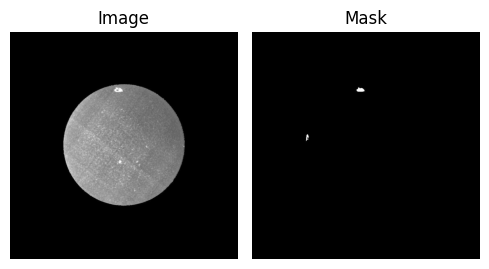

In [10]:
show_some_imgs_and_masks(1, train_file_names)

### **Prepare Data**

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_names, mask_names = None, transforms = None, train=True):
        super(CustomDataset, self).__init__()
        self.img_names = img_names
        self.mask_names = mask_names
        self.train = train
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img_path = path_file + self.img_names[idx]
        img = np.array(Image.open(img_path).convert("RGB"), dtype = np.float32) / 255.0
        
        if self.train:
            mask_path = path_masks_file + self.mask_names[idx]
            
#             mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32)
#             mask[mask == 255.0] = 1.0

            mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32) / 255.0
            mask  = np.where(mask > 0.5, 1.0, 0.0)
        
            if self.transforms:
                augmentations = self.transforms(image=img, mask=mask)
                img = augmentations["image"]
                mask = augmentations["mask"]
            mask = mask.unsqueeze(0)
            return img, mask
        
        if self.transforms:
            img = self.transforms(image=img)
        
        mask = mask.unsqueeze(0)
        return img, mask
        
    def __len__(self):
        return len(self.img_names)

#### **Data Augmentations**

In [12]:
IMAGE_HEIGHT = 800
IMAGE_WIDTH = 800

train_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    ToTensorV2()
])

### **Training and Validation Data**

In [13]:
split = int(len(train_file_names) * 0.82)

train_imgs = train_file_names[:split]
train_masks = train_masks_file_names[:split]

val_imgs = train_file_names[split:]
val_masks = train_masks_file_names[split:]

In [14]:
len(train_imgs), len(val_imgs)

(2091, 459)

In [15]:
batch_size = 2

train_ds = CustomDataset(train_imgs, train_masks, transforms=train_transforms)
val_ds = CustomDataset(val_imgs, val_masks, transforms=val_transforms)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [16]:
def show_batch(dl):
    for batch in dl:
        image, mask = batch
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,4))
        ax1.imshow(make_grid(image).permute(1,2,0))
        ax1.set_title('Input Images')
        ax1.axis('off')
        
        ax2.set_title('Input Masks')
        ax2.imshow(make_grid(mask).permute(1,2,0))  
        ax2.axis('off')
        
        fig.tight_layout()
        break

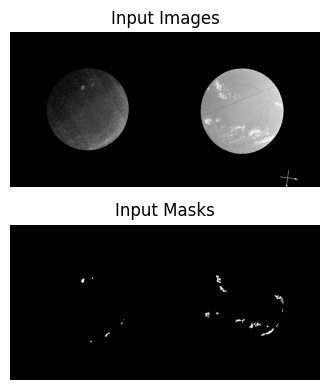

In [17]:
show_batch(train_dl)

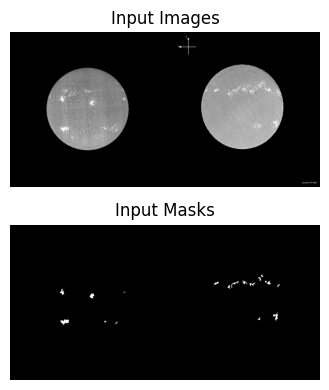

In [18]:
show_batch(val_dl)

### **Using GPUs**

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### **Wraper Functions to use during Training**

In [22]:
class BaseClass(nn.Module):
    def training_step(self, batch):
        inputs, targets = batch        
        preds = self(inputs)
        loss_fn = nn.BCEWithLogitsLoss()
        loss = loss_fn(preds, targets)
        return loss
    
    def validation_step(self, batch, score_fn):
        inputs, targets = batch
        preds = self(inputs)
        loss_fn = nn.BCEWithLogitsLoss()
        loss = loss_fn(preds, targets)
        score = score_fn(preds, targets)
        return {'val_loss': loss.detach(), 'val_score': score}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = sum(batch_losses)/len(batch_losses)
        
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = sum(batch_scores)/len(batch_scores)
        
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score}
    
    def epoch_end(self, epoch, nEpochs, results):
        print("Epoch: [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score:{:.4f}".format(
                        epoch+1, nEpochs, results['train_loss'], results['val_loss'], results['val_score']))


### **Model Architecture**

In [23]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size = 3,stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.block(x)

def copy_and_crop(down_layer, up_layer):
    b, ch, h, w = up_layer.shape
    crop = T.CenterCrop((h, w))(down_layer)
    return crop
    
class UNet(BaseClass):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder = nn.ModuleList([
            conv_block(in_channels, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512)
        ])
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottle_neck = conv_block(512, 1024)
        
        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])
        
        self.decoder = nn.ModuleList([
            conv_block(1024, 512),
            conv_block(512, 256),
            conv_block(256, 128),
            conv_block(128, 64)
        ])
        
        self.final_layer = nn.Conv2d(64, out_channels, 1, 1)
        
    def forward(self, x):
        skip_connections = []
        
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottle_neck(x)
        
        for ind, layer in enumerate(self.decoder):
            x = self.up_samples[ind](x)
            y = copy_and_crop(skip_connections.pop(), x)
            x = layer(torch.cat([y, x], dim=1))
        
        x = self.final_layer(x)
        
        return x

### **Training**

In [24]:
def dice_score(preds, targets):
    preds = F.sigmoid(preds)
    preds = (preds > 0.5).float()
    score = (2. * (preds * targets).sum()) / (preds + targets).sum()
    return torch.mean(score).item()

def evaluation(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch, dice_score) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def show_predicted_images(model, dl, n_images = batch_size):
    imgs, masks = next(iter(dl))
    logits = model(imgs)
    preds = F.sigmoid(logits)
    preds = (preds>0.5).float()
    
    fig,axs = plt.subplots(nrows=3, ncols=1)
    ax1, ax2, ax3 = axs
    fig.tight_layout()

    ax1.imshow(make_grid(imgs[:n_images].detach().cpu(), nrow=n_images).permute(1,2,0))
    ax1.set_title('Input Image')
    ax1.axis('off')
    
    ax2.imshow(make_grid(masks[:n_images].detach().cpu(), nrow=n_images).permute(1,2,0))
    ax2.set_title('Mask')
    ax2.axis('off')
    
    ax3.imshow(make_grid(preds[:n_images].detach().cpu(), nrow=n_images).permute(1,2,0))
    ax3.set_title('Pred Mask')
    ax3.axis('off')
    
    plt.show()

In [25]:
def fit(epochs, lr, model, train_dl, val_dl, opt_func, print_after):
    history = []
    optimizer = opt_func(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.detach())
        
        # Validation
        result = evaluation(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        history.append(result)
        
        model.epoch_end(epoch, epochs, result)
        if epoch%print_after == 0:
            show_predicted_images(model, val_dl, n_images=4)
        
    return history

In [26]:
model = to_device(UNet(3, 1), device)

In [27]:
lr = 1e-4
epochs = 20
opt_func = torch.optim.Adam

In [28]:
history = [evaluation(model, val_dl)]

In [29]:
history

[{'val_loss': 0.7300016760447703, 'val_score': 0.008363786149934585}]

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [1/20], train_loss: 0.1907, val_loss: 0.0722, val_score:0.6753


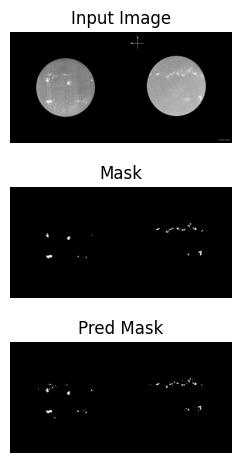

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [2/20], train_loss: 0.0415, val_loss: 0.0248, val_score:0.6833


  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [3/20], train_loss: 0.0182, val_loss: 0.0125, val_score:0.6623


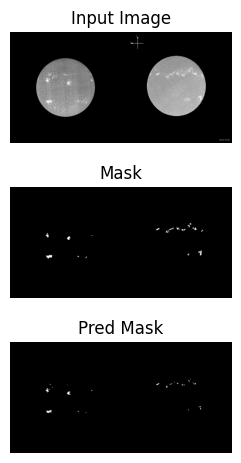

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [4/20], train_loss: 0.0112, val_loss: 0.0244, val_score:0.5593


  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [5/20], train_loss: 0.0085, val_loss: 0.0066, val_score:0.7278


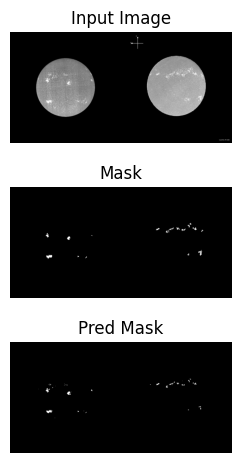

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [6/20], train_loss: 0.0071, val_loss: 0.0081, val_score:0.5227


  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [7/20], train_loss: 0.0063, val_loss: 0.0060, val_score:0.7402


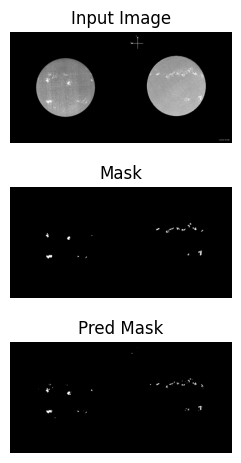

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [8/20], train_loss: 0.0060, val_loss: 0.0051, val_score:0.7107


  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [9/20], train_loss: 0.0055, val_loss: 0.0050, val_score:0.7341


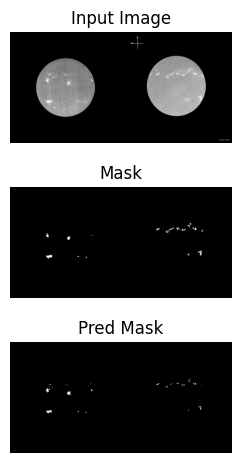

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [10/20], train_loss: 0.0054, val_loss: 0.0051, val_score:0.6834


  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [11/20], train_loss: 0.0053, val_loss: 0.0048, val_score:0.7161


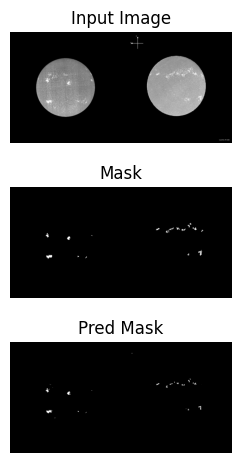

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [12/20], train_loss: 0.0053, val_loss: 0.0043, val_score:0.7582


  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [13/20], train_loss: 0.0050, val_loss: 0.0045, val_score:0.7655


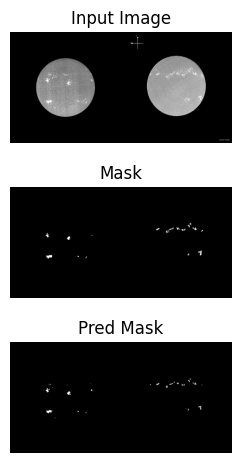

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [14/20], train_loss: 0.0052, val_loss: 0.0053, val_score:0.6868


  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [15/20], train_loss: 0.0051, val_loss: 0.0046, val_score:0.7124


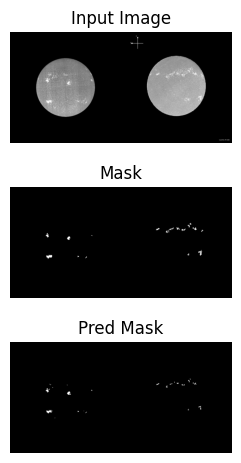

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [16/20], train_loss: 0.0050, val_loss: 0.0047, val_score:0.7162


  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [17/20], train_loss: 0.0049, val_loss: 0.0060, val_score:0.6559


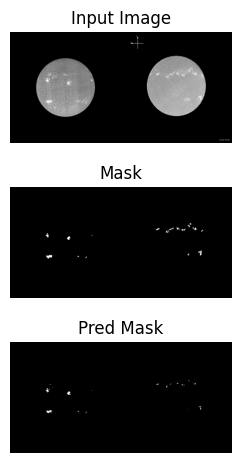

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [18/20], train_loss: 0.0049, val_loss: 0.0046, val_score:0.7401


  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [19/20], train_loss: 0.0050, val_loss: 0.0042, val_score:0.7669


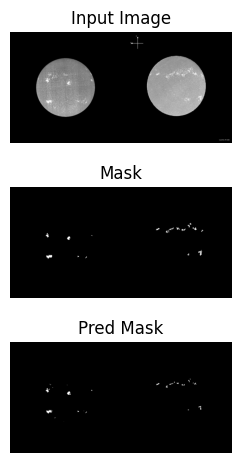

  0%|          | 0/1046 [00:00<?, ?it/s]

Epoch: [20/20], train_loss: 0.0048, val_loss: 0.0055, val_score:0.6935


[{'val_loss': 0.7300016760447703, 'val_score': 0.008363786149934585},
 {'val_loss': 0.07223555044903104,
  'val_score': 0.6753378640645151,
  'train_loss': 0.19069249252925627},
 {'val_loss': 0.024824117632221664,
  'val_score': 0.68334836579922,
  'train_loss': 0.04149692303815288},
 {'val_loss': 0.012485877987344922,
  'val_score': 0.6622881665899146,
  'train_loss': 0.018199003220228438},
 {'val_loss': 0.02440137766397151,
  'val_score': 0.5593379387562252,
  'train_loss': 0.011211100474365921},
 {'val_loss': 0.006645462943241174,
  'val_score': 0.7278218455156341,
  'train_loss': 0.008456218912829695},
 {'val_loss': 0.008140896230840002,
  'val_score': 0.5227153329029175,
  'train_loss': 0.007062538871313641},
 {'val_loss': 0.00604541478546057,
  'val_score': 0.7401547004140399,
  'train_loss': 0.006280045399795581},
 {'val_loss': 0.005063344889913095,
  'val_score': 0.7107440760852349,
  'train_loss': 0.005984949978577351},
 {'val_loss': 0.0049838447650869125,
  'val_score': 0.734

In [30]:
history += fit(epochs, lr, model, train_dl, val_dl, opt_func, print_after=2)
history

### **Plots** 

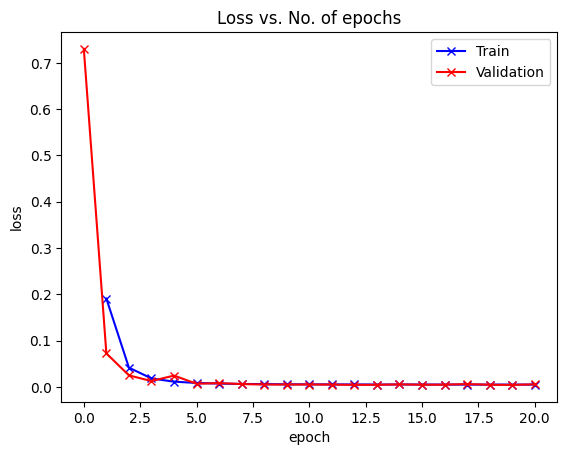

In [31]:
# Plot Figures
train_losses = [ele.get('train_loss') for ele in history]
val_losses = [ele.get('val_loss') for ele in history]

#plt.figure(figsize=(16, 10))
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.title('Loss vs. No. of epochs');

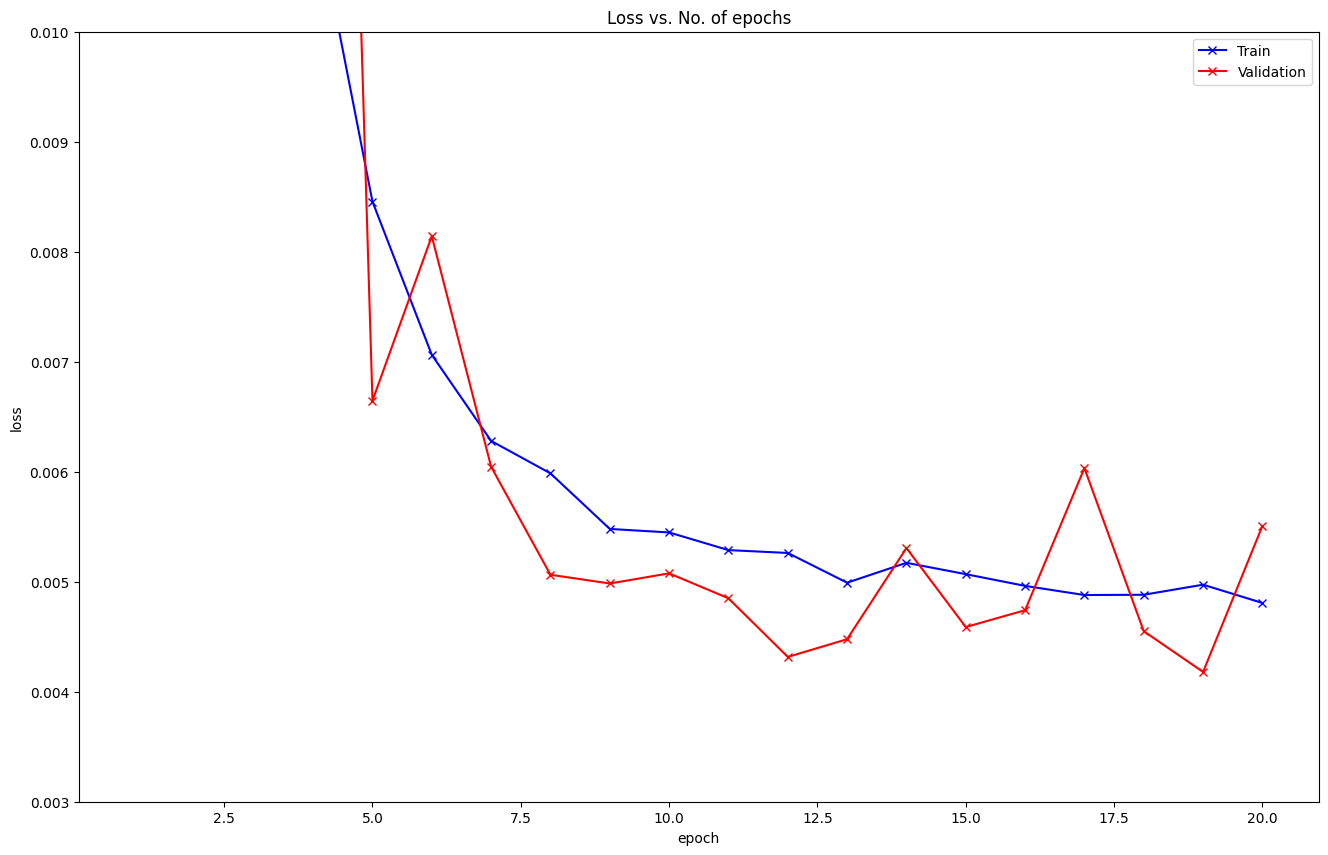

In [32]:
# Plot Figures
train_losses = [ele.get('train_loss') for ele in history]
val_losses = [ele.get('val_loss') for ele in history]

epoch = list(range(1,21))

plt.figure(figsize=(16, 10))
plt.plot(epoch,train_losses[1:], '-bx')
plt.plot(epoch,val_losses[1:], '-rx')

  # Set the x-axis limits
plt.ylim(0.003, 0.01)
# plt.xlim(0, 21)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.title('Loss vs. No. of epochs');

### Save train and val losses

In [33]:
import csv
csv_file_name = "/kaggle/working/loss_report_e20b2.csv"

epochs = list(range(epochs+1))
val_scores  = [ele.get('val_score') for ele in history]

# Open the CSV file in write mode
with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row (optional)
    writer.writerow(['epoch','train_losses','val_losses', 'val_scores'])
    
    # Write data from the lists to the CSV file
    for item1, item2, item3, item4 in zip(epochs, train_losses, val_losses, val_scores):
        writer.writerow([item1, item2, item3, item4])

print(f'CSV file "{csv_file_name}" has been created.')

CSV file "/kaggle/working/loss_report_e20b2.csv" has been created.


### **Prediction**

In [34]:
def predict_mask(img_path):
    img = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255.0
    img_t = val_transforms(image=img)['image'].to(device)
    
    logits = model(img_t.unsqueeze(0)).detach().cpu()
    preds = F.sigmoid(logits)
    preds = (preds>0.5).float().detach().cpu()
    
    plt.imshow(preds[0].permute(1,2,0), cmap='gray')
    plt.axis('off')

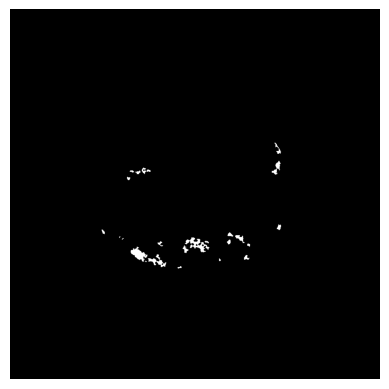

In [35]:
img_path = path_file+val_imgs[8]
predict_mask(img_path)

In [36]:
torch.save(model.state_dict(), 'unet_segmentation_e20b2.pth')

### Caluclate IOU value on test images

In [37]:
def predict_mask(img_path):
    img = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255.0
    img_t = val_transforms(image=img)['image'].to(device)
    
    logits = model(img_t.unsqueeze(0)).detach().cpu()
    preds = F.sigmoid(logits)
    preds = (preds>0.5).float().detach().cpu()
    #print(np.unique(preds[0].permute(1,2,0)))

    plt.imshow(preds[0][0], cmap='gray')
    plt.axis('off')
    
    return preds[0][0]

In [38]:
def calculate_iou(mask1, mask2):
    # Calculate intersection and union
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    
    # Compute IOU
    iou = np.sum(intersection) / np.sum(union)
    
    return iou


/tmp/ipykernel_24/3823993742.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(torch.tensor(predicted_mask,dtype=torch.float32), torch.tensor(mask_img, dtype=torch.float32))


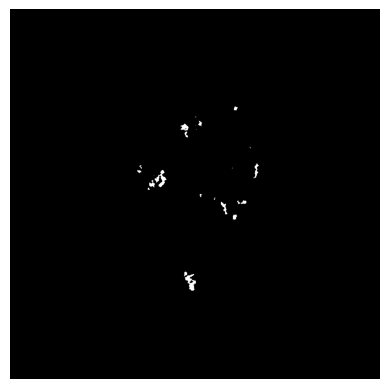

In [39]:
loss_fn = nn.BCEWithLogitsLoss()

test_loss = []
iou_values  = []
for i in range(len(test_file_names)):
    
    img_path = path_file+test_file_names[i]
    predicted_mask = predict_mask(img_path)
    
    mask_path = path_masks_file+test_masks_file_names[i]
    img = np.array(Image.open(mask_path), dtype=np.float32) / 255.0
    mask_img = (img > 0.5).astype(float)
    
    loss = loss_fn(torch.tensor(predicted_mask,dtype=torch.float32), torch.tensor(mask_img, dtype=torch.float32))
    test_loss.append(loss.item())
    
    iou_value = calculate_iou(mask_img, np.array(predicted_mask))
    iou_values.append(iou_value)

#### Writing IOU values to csv files

In [40]:
import csv

csv_file_name = "/kaggle/working/loss_IOU_values_e20b2.csv"
# Open the CSV file in write mode
with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row (optional)
    writer.writerow(['image_name','test_loss','IOU_values'])
    
    # Write data from the lists to the CSV file
    for item1, item2, item3 in zip(test_masks_file_names,test_loss, iou_values):
        writer.writerow([item1, item2, item3])

print(f'CSV file "{csv_file_name}" has been created.')

CSV file "/kaggle/working/loss_IOU_values_e20b2.csv" has been created.


In [41]:
avarage_iou = sum(iou_values)/len(iou_values)
average_test_loss = sum(test_loss)/len(test_loss)

In [42]:
print(f'average IOU value {avarage_iou} \n and average test loss: {average_test_loss}')

average IOU value 0.5146103853371696 
 and average test loss: 0.6925009976492987
